# Data Analytics Project - Models

# Pair 3 - TWL LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 3 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

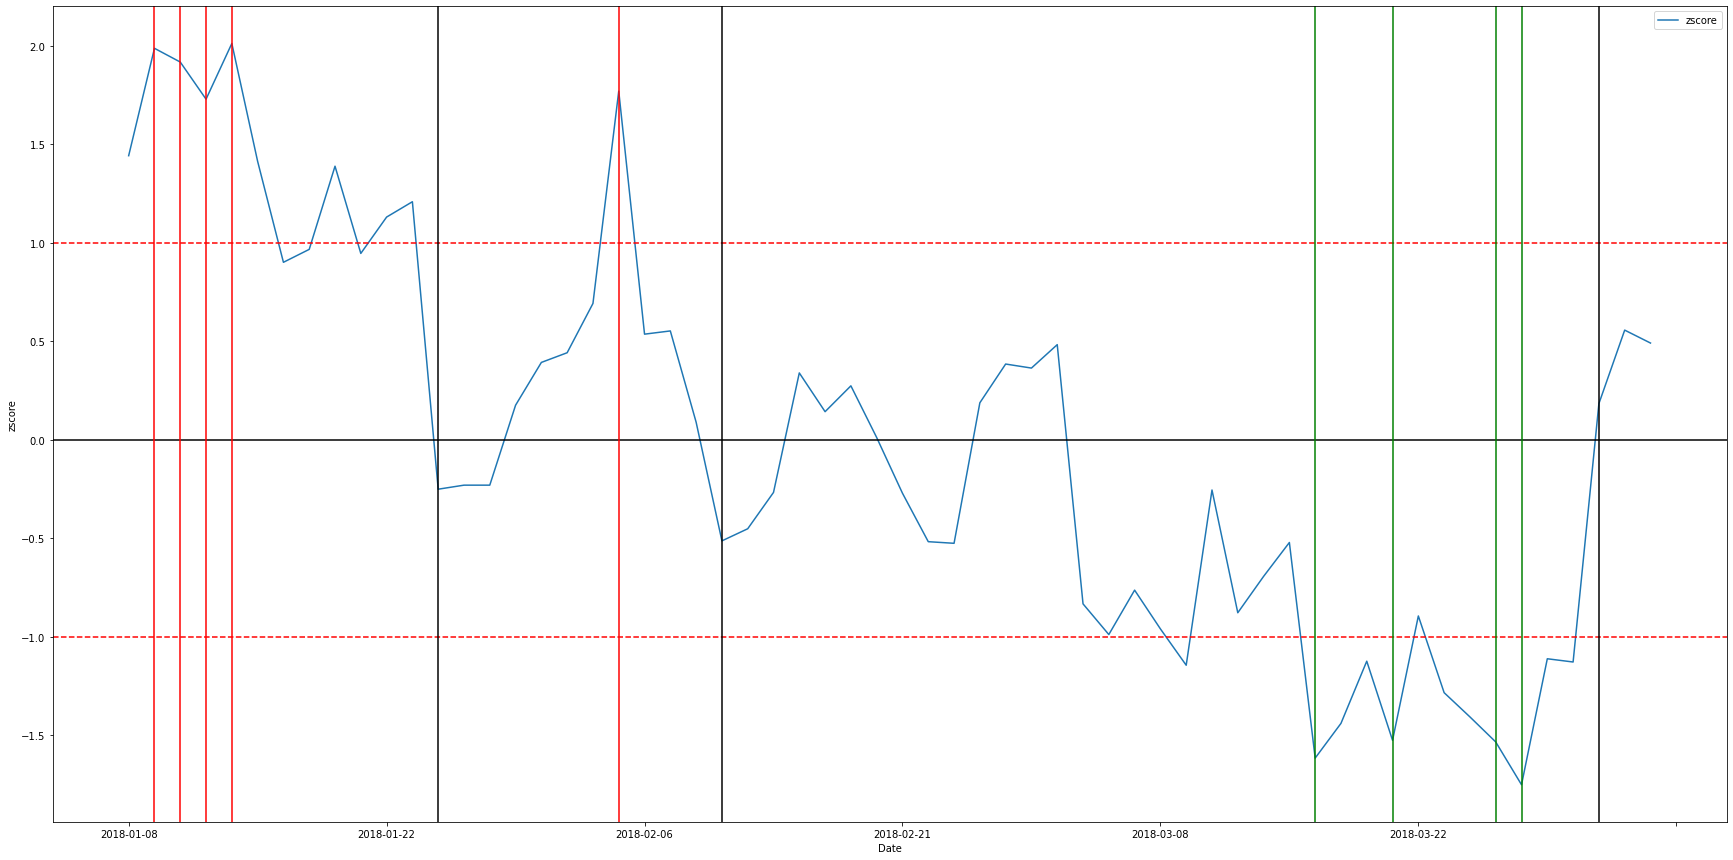

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

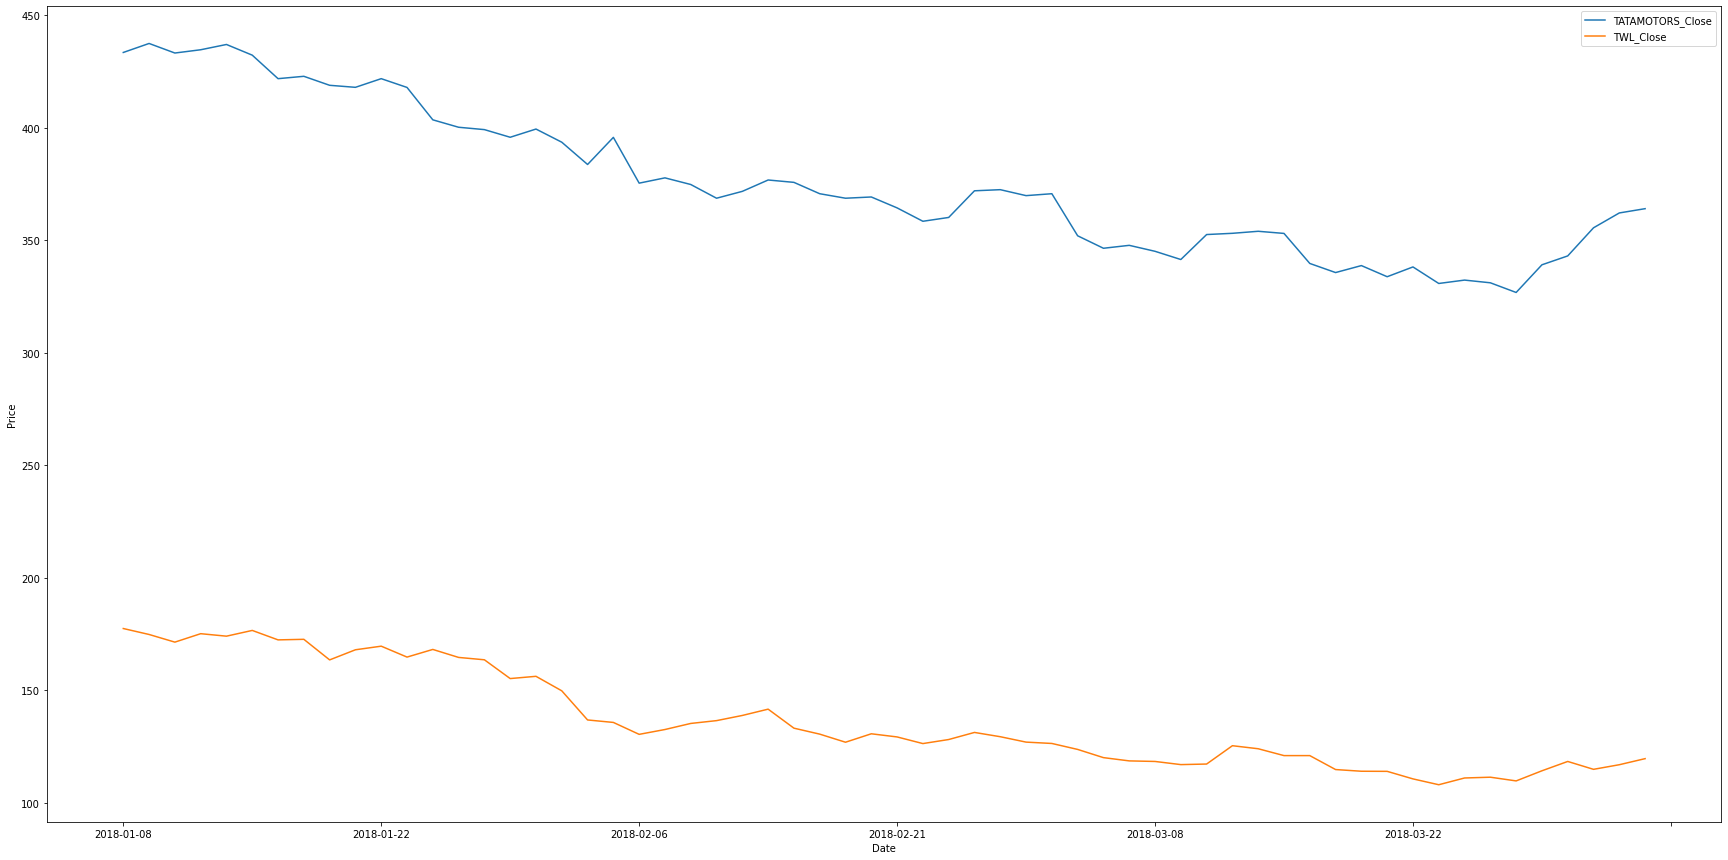

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TATAMOTORS_Close', 'TWL_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TWL Linear Regression Model

## 3.1. Get the Complete TWL dataset

In [6]:
twl_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TWLNSE.csv")
twl_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,125.800003,122.699997,124.000000,125.150002,657433.0,122.965851,TWL,NSE
1,2017-01-03,132.899994,125.500000,126.150002,130.800003,2992973.0,128.517227,TWL,NSE
2,2017-01-04,132.300003,127.000000,131.600006,128.449997,1281617.0,126.208244,TWL,NSE
3,2017-01-05,129.649994,124.099998,129.000000,126.900002,1125281.0,124.685303,TWL,NSE
4,2017-01-06,129.350006,125.550003,127.400002,127.400002,841568.0,125.176567,TWL,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TWL training data

### 3.2.1 Get complete twl dataset

In [7]:
twl_df = twl_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
twl_df.head()

,Date,Close
0,2017-01-02,125.150002
1,2017-01-03,130.800003
2,2017-01-04,128.449997
3,2017-01-05,126.900002
4,2017-01-06,127.400002


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
twl_df_train = twl_df[twl_df['Date'] >= '2017-09-03']
twl_df_train.head()

,Date,Close
166,2017-09-04,115.349998
167,2017-09-05,119.500000
168,2017-09-06,118.150002
169,2017-09-07,115.599998
170,2017-09-08,115.849998


In [9]:
twl_df_train = twl_df_train[twl_df_train['Date'] <= '2018-09-04']
twl_df_train.tail()

,Date,Close
412,2018-08-29,88.949997
413,2018-08-30,88.849998
414,2018-08-31,88.500000
415,2018-09-03,87.849998
416,2018-09-04,86.050003


### 3.2.3 Get the training data

In [10]:
twl_train = twl_df_train.copy()

In [11]:
twl_train = twl_train.reset_index(drop=True)
twl_train = twl_train.copy()
twl_train.head()

,Date,Close
0,2017-09-04,115.349998
1,2017-09-05,119.500000
2,2017-09-06,118.150002
3,2017-09-07,115.599998
4,2017-09-08,115.849998


In [12]:
twl_train_plot_copy = twl_train.copy()
twl_train.tail()

,Date,Close
246,2018-08-29,88.949997
247,2018-08-30,88.849998
248,2018-08-31,88.500000
249,2018-09-03,87.849998
250,2018-09-04,86.050003


In [13]:
twl_train = twl_train.drop(columns=['Date'])
twl_train = twl_train.values
twl_train

array([[115.34999847],
       [119.5       ],
       [118.15000153],
       [115.59999847],
       [115.84999847],
       [115.5       ],
       [117.        ],
       [115.55000305],
       [115.65000153],
       [115.34999847],
       [117.05000305],
       [117.75      ],
       [126.30000305],
       [124.80000305],
       [118.25      ],
       [117.80000305],
       [123.90000153],
       [119.44999695],
       [120.44999695],
       [120.5       ],
       [119.30000305],
       [122.90000153],
       [124.5       ],
       [123.30000305],
       [123.19999695],
       [124.05000305],
       [124.75      ],
       [126.55000305],
       [126.        ],
       [126.65000153],
       [126.34999847],
       [125.09999847],
       [125.59999847],
       [125.15000153],
       [125.5       ],
       [124.69999695],
       [133.6499939 ],
       [137.1499939 ],
       [139.8500061 ],
       [143.6000061 ],
       [141.6499939 ],
       [139.        ],
       [138.8500061 ],
       [147

In [14]:
len(twl_train)

251

## 3.3. Get TWL Test Data

In [15]:
twl_test = twl_df[(twl_df['Date'] >= '2018-09-04') & (twl_df['Date'] <= '2018-12-03')].copy()
twl_test.head()

,Date,Close
416,2018-09-04,86.050003
417,2018-09-05,84.900002
418,2018-09-06,85.949997
419,2018-09-07,87.349998
420,2018-09-10,86.199997


In [16]:
twl_test.tail()

,Date,Close
470,2018-11-27,70.699997
471,2018-11-28,69.599998
472,2018-11-29,68.500000
473,2018-11-30,68.800003
474,2018-12-03,69.699997


In [17]:
twl_test.reset_index(drop=True, inplace=True)
twl_test.index += 251
twl_test.head()

,Date,Close
251,2018-09-04,86.050003
252,2018-09-05,84.900002
253,2018-09-06,85.949997
254,2018-09-07,87.349998
255,2018-09-10,86.199997


In [18]:
twl_test_plot_copy = twl_test.copy()
twl_test = twl_test.drop(columns=['Date'])
twl_test = twl_test.values
twl_test

array([[86.05000305],
       [84.90000153],
       [85.94999695],
       [87.34999847],
       [86.19999695],
       [85.44999695],
       [87.44999695],
       [89.05000305],
       [87.40000153],
       [85.25      ],
       [84.55000305],
       [79.44999695],
       [76.        ],
       [76.65000153],
       [76.94999695],
       [74.94999695],
       [70.69999695],
       [69.75      ],
       [72.75      ],
       [71.25      ],
       [68.25      ],
       [67.09999847],
       [62.45000076],
       [65.05000305],
       [66.5       ],
       [68.09999847],
       [69.59999847],
       [71.09999847],
       [69.19999695],
       [68.84999847],
       [68.19999695],
       [67.90000153],
       [68.34999847],
       [66.69999695],
       [66.34999847],
       [68.19999695],
       [66.84999847],
       [67.34999847],
       [69.69999695],
       [70.80000305],
       [70.44999695],
       [70.55000305],
       [71.5       ],
       [72.09999847],
       [74.        ],
       [73

In [19]:
len(twl_test)

59

## 3.4 Create and Train TWL Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(twl_train)
scaled_train_data

array([[0.38482025],
       [0.42166003],
       [0.40967602],
       [0.38703951],
       [0.38925877],
       [0.38615182],
       [0.3994674 ],
       [0.3865957 ],
       [0.38748339],
       [0.38482025],
       [0.39991128],
       [0.40612519],
       [0.48202402],
       [0.46870844],
       [0.41056372],
       [0.40656907],
       [0.46071908],
       [0.42121615],
       [0.43009321],
       [0.43053709],
       [0.41988465],
       [0.45184203],
       [0.4660453 ],
       [0.45539286],
       [0.4545051 ],
       [0.46205065],
       [0.46826456],
       [0.48424328],
       [0.47936088],
       [0.48513098],
       [0.48246783],
       [0.47137152],
       [0.47581004],
       [0.4718154 ],
       [0.47492235],
       [0.46782068],
       [0.54727028],
       [0.57833997],
       [0.60230812],
       [0.63559707],
       [0.61828671],
       [0.59476257],
       [0.59343107],
       [0.6706614 ],
       [0.62272523],
       [0.67021752],
       [0.66355973],
       [0.607

In [21]:
X_train, y_train = [], []
for i in range(10,len(twl_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0132


## 3.5. Get predictions

In [24]:
scaled_test_data = twl_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.12472263,  0.114514  ,  0.12383487,  0.13626275,  0.12605413,
         0.11939634,  0.13715045,  0.15135379,  0.13670663,  0.11762096],
       [ 0.114514  ,  0.12383487,  0.13626275,  0.12605413,  0.11939634,
         0.13715045,  0.15135379,  0.13670663,  0.11762096,  0.11140705],
       [ 0.12383487,  0.13626275,  0.12605413,  0.11939634,  0.13715045,
         0.15135379,  0.13670663,  0.11762096,  0.11140705,  0.06613402],
       [ 0.13626275,  0.12605413,  0.11939634,  0.13715045,  0.15135379,
         0.13670663,  0.11762096,  0.11140705,  0.06613402,  0.03550821],
       [ 0.12605413,  0.11939634,  0.13715045,  0.15135379,  0.13670663,
         0.11762096,  0.11140705,  0.06613402,  0.03550821,  0.04127831],
       [ 0.11939634,  0.13715045,  0.15135379,  0.13670663,  0.11762096,
         0.11140705,  0.06613402,  0.03550821,  0.04127831,  0.04394139],
       [ 0.13715045,  0.15135379,  0.13670663,  0.11762096,  0.11140705,
         0.06613402,  0.03550821,  0.04127831

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(twl_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(twl_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(twl_test[10:], closing_price)))

Mean Absolute Error: 6.856963566371371
Mean Squared Error: 61.297026868830265
Root Mean Squared Error: 7.829241781221874


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    89.383934
261    89.366341
262    89.139870
263    88.490753
264    87.542007
265    86.574081
266    85.539818
267    84.158081
268    82.535339
269    81.101753
270    79.855461
271    78.605591
272    77.634506
273    76.669456
274    75.608299
275    74.589790
276    73.847412
277    73.558578
278    73.512016
279    73.339890
280    73.311699
281    73.468811
282    73.655815
283    74.104813
284    74.265114
285    74.237328
286    74.117126
287    73.878075
288    73.562012
289    73.486603
290    73.560562
291    73.754860
292    74.018013
293    74.312523
294    74.770180
295    75.340591
296    75.826332
297    76.389580
298    76.869507
299    77.146614
300    77.425880
301    77.751343
302    78.074699
303    78.281403
304    78.334549
305    78.151855
306    77.887070
307    77.545082
308    77.160164
Name: price, dtype: float32

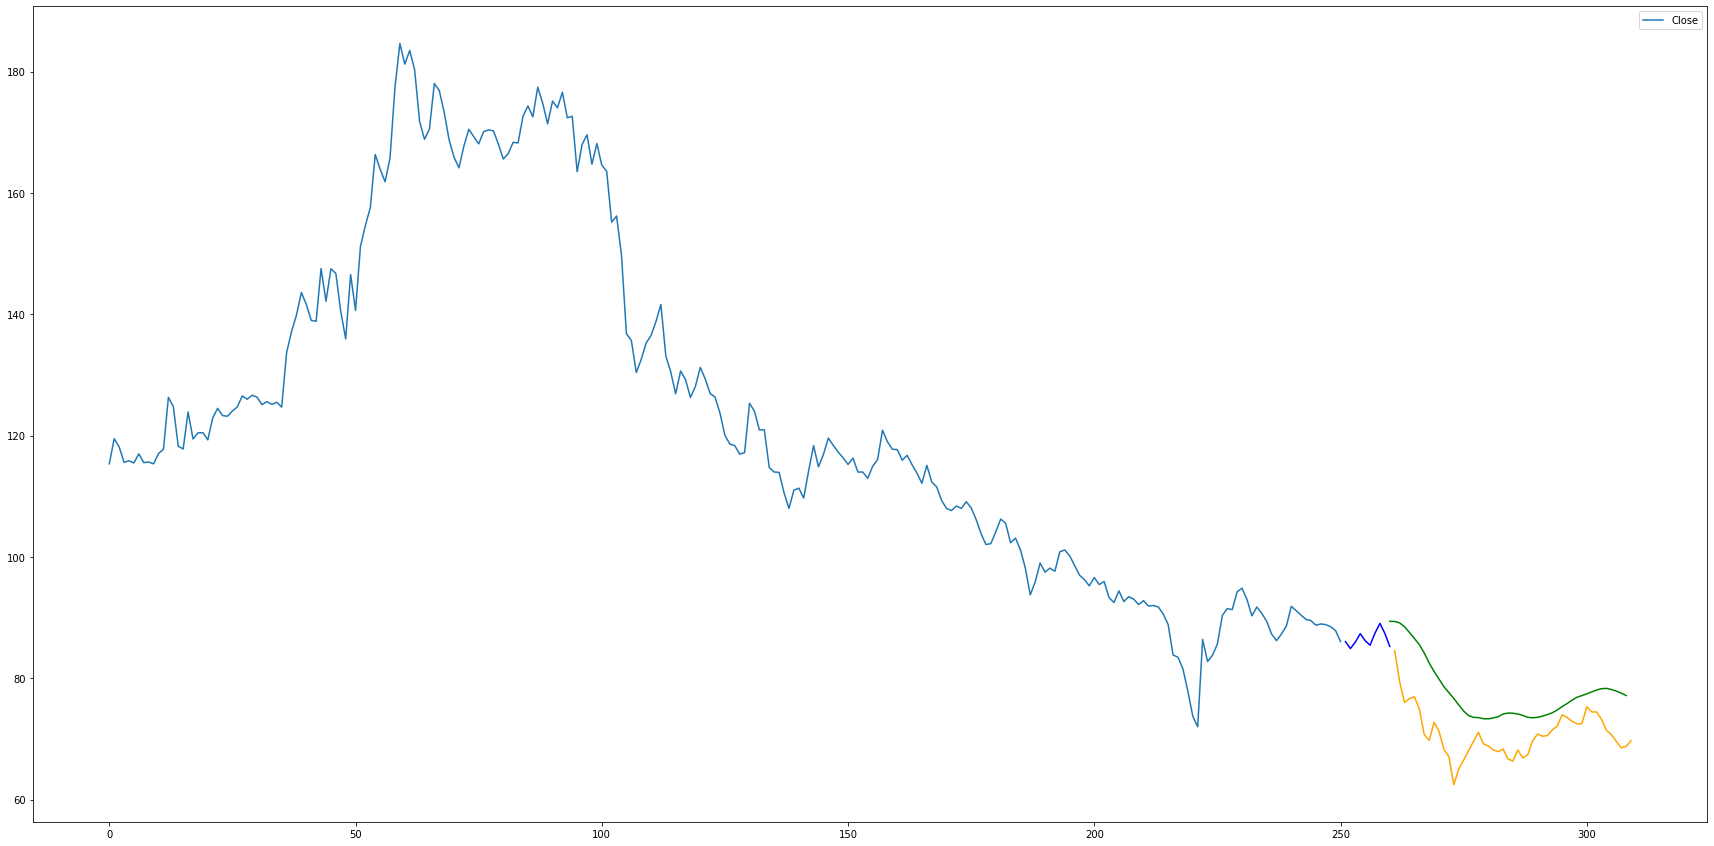

In [29]:
twl_model_plt = twl_train_plot_copy.plot(y=['Close'], figsize=(30,15))
twl_model_plt.plot(twl_test_plot_copy["Close"][:10], c='blue')
twl_model_plt.plot(twl_test_plot_copy["Close"][10:], c='orange')
twl_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
twl_predictions_df = pd.read_csv('Twl_predicitions.csv')
twl_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-01-08,177.449997,97.123234,86.276492
1,2018-01-09,174.800003,97.166994,85.608620
2,2018-01-10,171.399994,97.210755,86.225199
3,2018-01-11,175.149994,97.254516,85.538993
4,2018-01-12,174.050003,96.775293,83.449136


In [31]:
twl_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
55,2018-04-02,114.199997,87.003833,79.654402
56,2018-04-03,118.349998,87.047594,78.591707
57,2018-04-04,114.849998,91.021466,77.842161
58,2018-04-05,116.900002,77.498945,77.416216
59,2018-04-06,119.599998,NaN,NaN


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,89.383934
11,89.366341
12,89.139870
13,88.490753
14,87.542007
15,86.574081
16,85.539818
17,84.158081
18,82.535339
19,81.101753


In [33]:
twl_predictions_df['LSTM_Close'] = closing_price_df['price']
twl_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-01-08,177.449997,97.123234,86.276492,NaN
1,2018-01-09,174.800003,97.166994,85.608620,NaN
2,2018-01-10,171.399994,97.210755,86.225199,NaN
3,2018-01-11,175.149994,97.254516,85.538993,NaN
4,2018-01-12,174.050003,96.775293,83.449136,NaN
5,2018-01-15,176.600006,96.819054,81.107538,NaN
6,2018-01-16,172.399994,96.862814,80.754823,NaN
7,2018-01-17,172.649994,96.950336,85.303755,NaN
8,2018-01-18,163.500000,96.471113,83.612673,NaN
9,2018-01-19,168.000000,96.514873,83.149529,NaN


In [34]:
twl_predictions_df.to_csv('Twl_predicitions.csv', index=False)